In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu, fu
from pandas import DataFrame, Index, Series
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import statsmodels.api as sm


# Develop the Euclidean Distance to Last Engagement Metric

In [5]:

# load data frames
data_frames_dict = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df', distance_delta_df='distance_delta_df', summary_statistics_df='summary_statistics_df')
frvrs_logs_df = data_frames_dict['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/home/dbabbitt/anaconda3/envs/itm_analysis_reporting/lib/python3.7/site-packages/pandas/_libs/internals.cpython-37m-x86_64-linux-gnu.so'>
No pickle exists for frvrs_logs_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/frvrs_logs_df.csv.
(829116, 113)



## Develop an Ideal Order of Engagement

In [9]:

base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False) & (frvrs_logs_df.is_a_one_triage_file == True)
distance_delta_df = data_frames_dict['distance_delta_df']


This more subtle Ideal Engagement Order ends up being compared, sometimes, to the Actual Engagement Order of a responder who engaged a walker before telling all patients who can walk to move to the safe area. So you get this weird bimodal distribution:

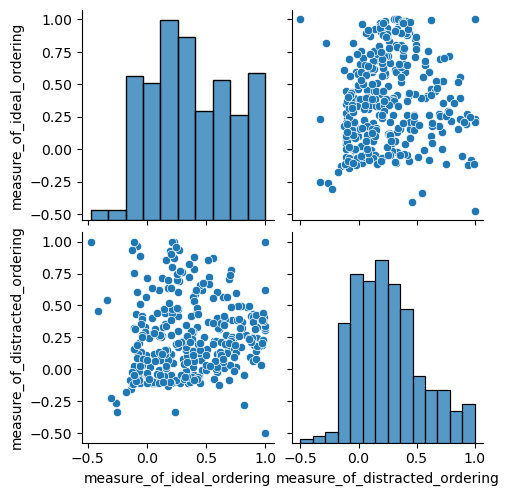

In [8]:

columns_list = ['measure_of_ideal_ordering', 'measure_of_distracted_ordering']
PairGrid_obj = sns.pairplot(distance_delta_df[columns_list])

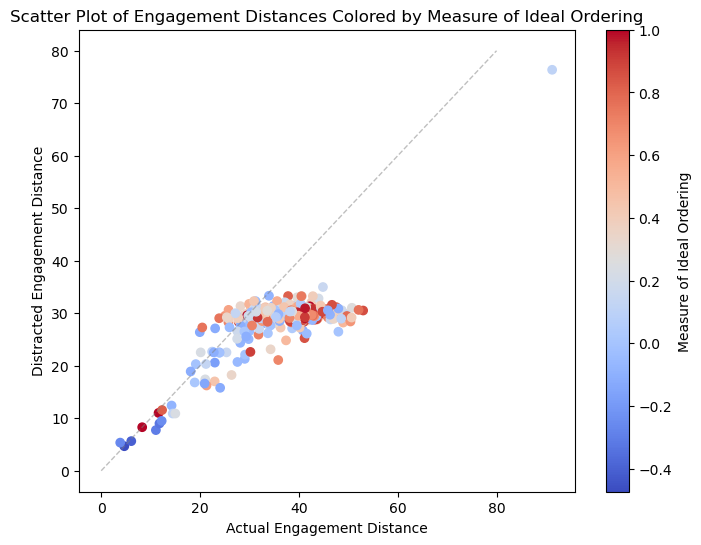

In [50]:

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    distance_delta_df['actual_engagement_distance'], distance_delta_df['distracted_engagement_distance'], c=distance_delta_df['measure_of_ideal_ordering'], cmap=cmap
)

# Add labels and title
plt.xlabel('Actual Engagement Distance')
plt.ylabel('Distracted Engagement Distance')
plt.title('Scatter Plot of Engagement Distances Colored by Measure of Ideal Ordering')

# Add a colorbar
plt.colorbar(label='Measure of Ideal Ordering')

# Add a dashed diagonal line x=y
plt.plot([0, 80], [0, 80], linestyle='--', color='gray', linewidth=1, alpha=0.5);

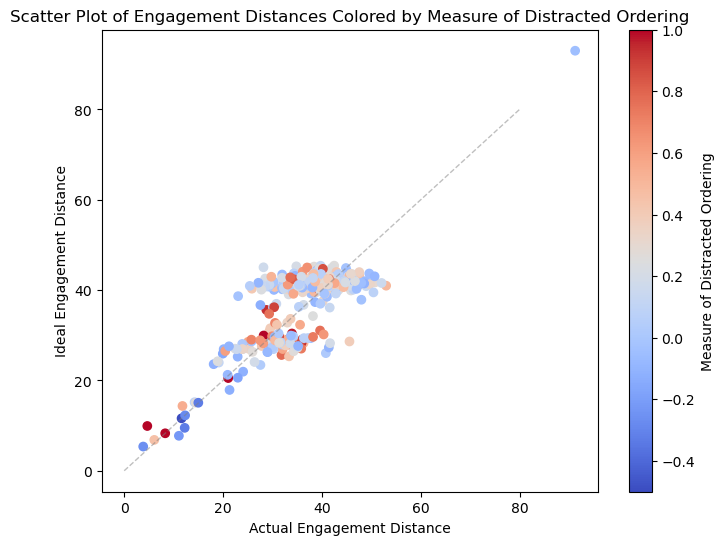

In [51]:

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(distance_delta_df['actual_engagement_distance'], distance_delta_df['ideal_engagement_distance'], c=distance_delta_df['measure_of_distracted_ordering'], cmap=cmap)

# Add labels and title
plt.xlabel('Actual Engagement Distance')
plt.ylabel('Ideal Engagement Distance')
plt.title('Scatter Plot of Engagement Distances Colored by Measure of Distracted Ordering')

# Add a colorbar
plt.colorbar(label='Measure of Distracted Ordering')

# Add a dashed diagonal line x=y
plt.plot([0, 80], [0, 80], linestyle='--', color='gray', linewidth=1, alpha=0.5);

In [9]:

sorted(distance_delta_df.columns)

['actual_distracted_delta', 'actual_engagement_distance', 'actual_ideal_delta', 'distracted_engagement_distance', 'ideal_engagement_distance', 'last_still_engagement', 'measure_of_distracted_ordering', 'measure_of_ideal_ordering', 'scene_id', 'session_uuid']

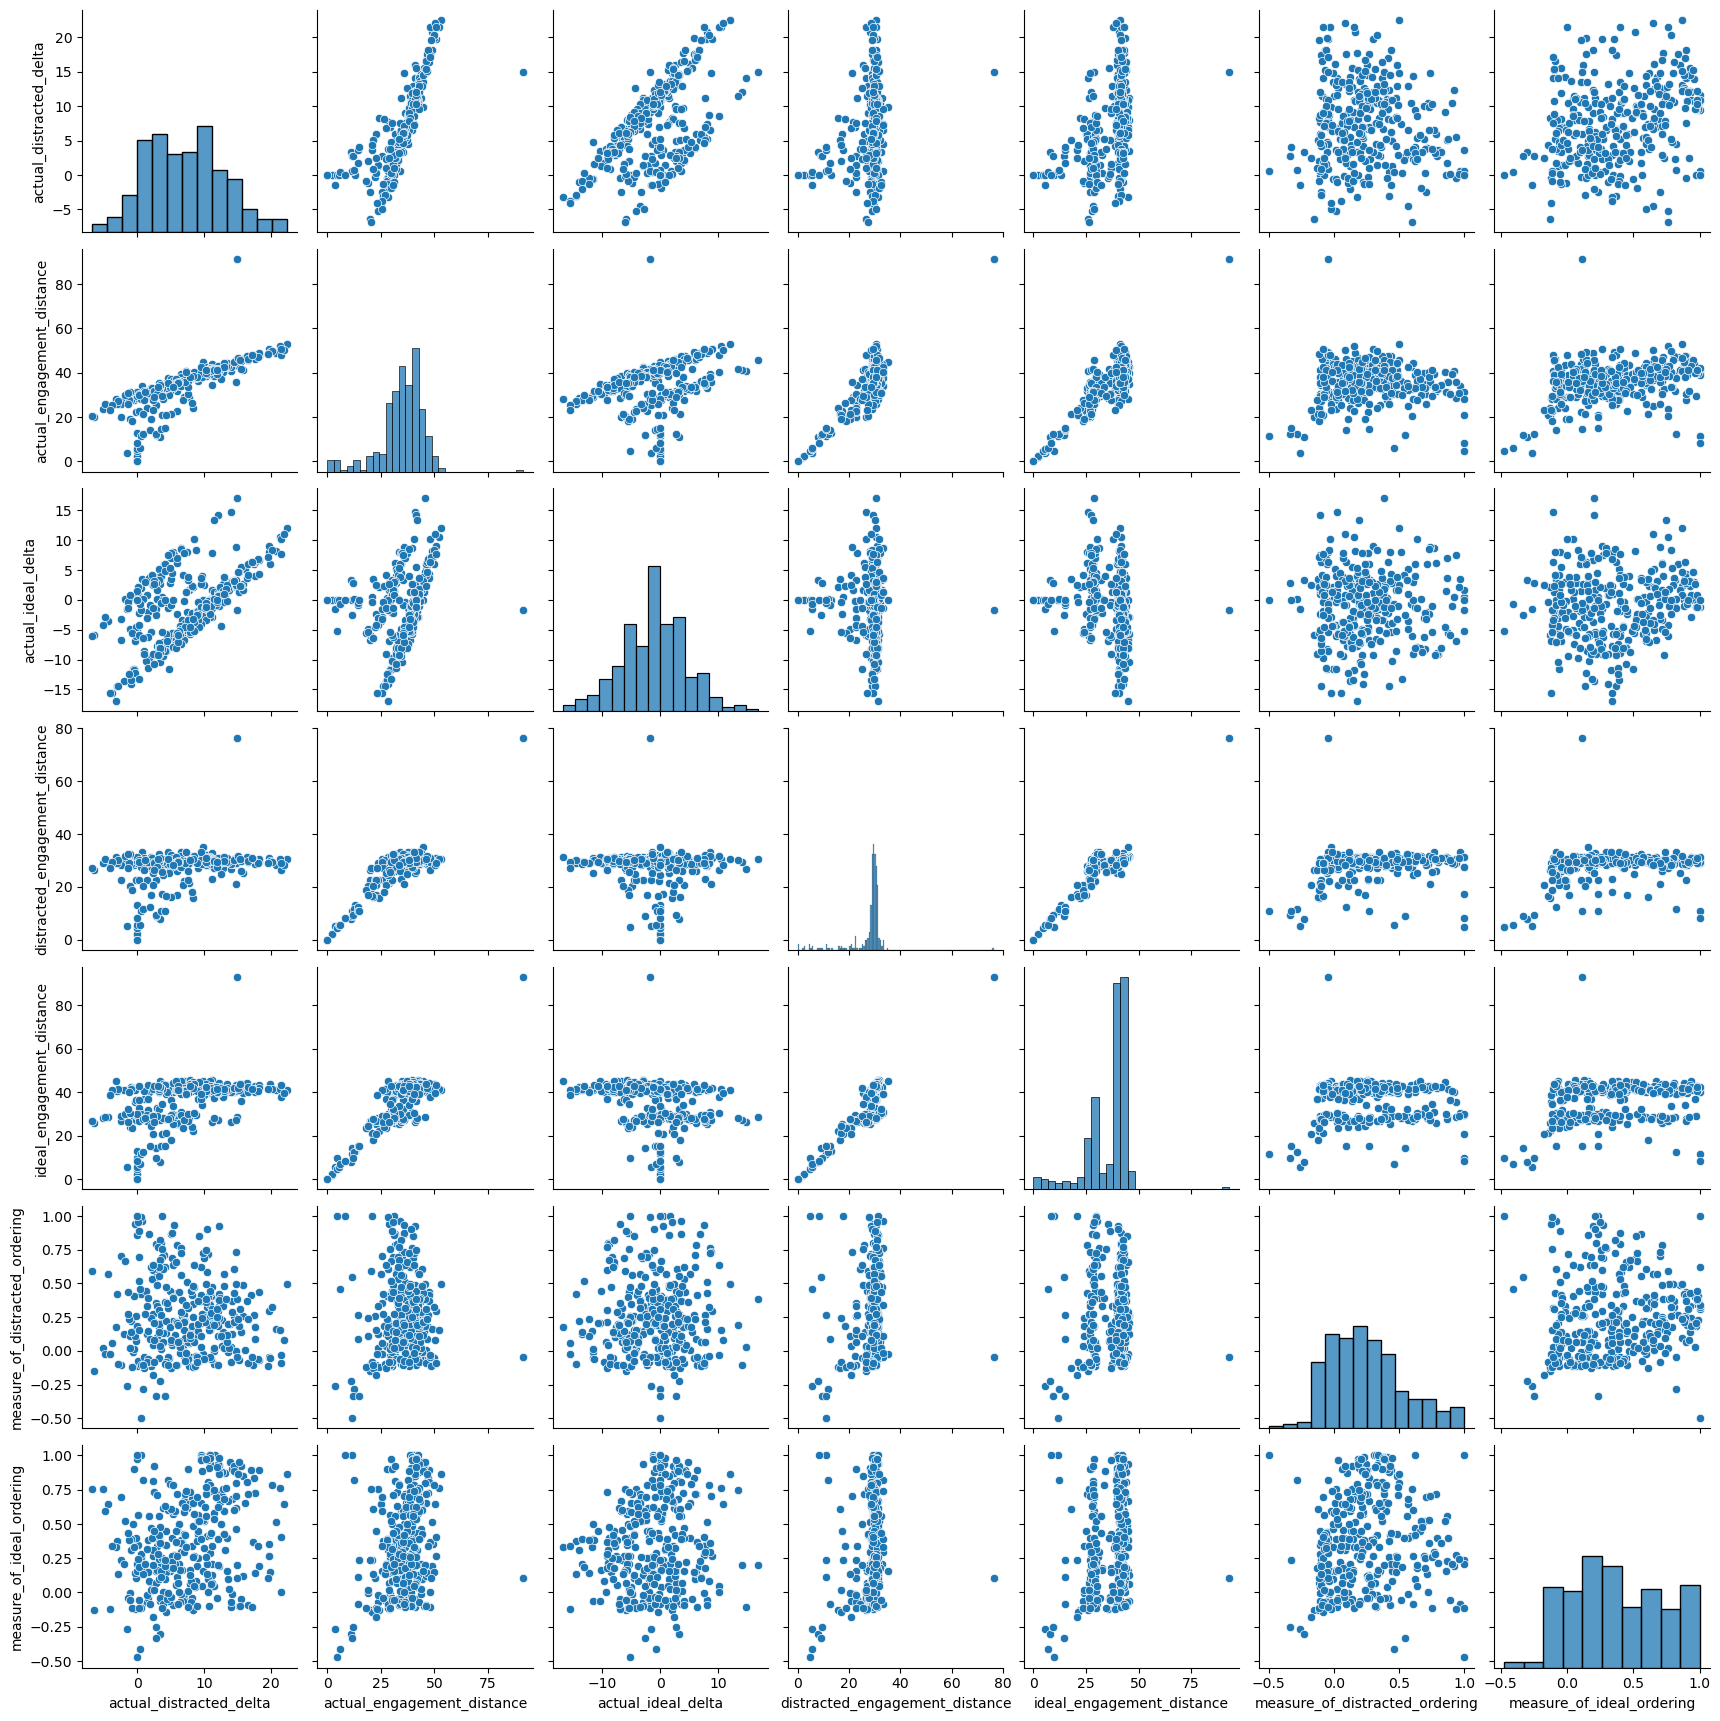

In [10]:

columns_list = [
    'actual_distracted_delta', 'actual_engagement_distance', 'actual_ideal_delta', 'distracted_engagement_distance', 'ideal_engagement_distance',
    'measure_of_distracted_ordering', 'measure_of_ideal_ordering'
]
PairGrid_obj = sns.pairplot(distance_delta_df[columns_list])

In [45]:

columns_list = [
    'actual_distracted_delta', 'actual_engagement_distance', 'actual_ideal_delta', 'distracted_engagement_distance', 'ideal_engagement_distance',
    'measure_of_distracted_ordering', 'measure_of_ideal_ordering'
]
series_dict = distance_delta_df[columns_list].corr().to_dict(orient='series')
corr_tuples_list = []
for cn, cn_srs in series_dict.items():
    mask_srs = (cn_srs < 1.0)
    srs = cn_srs[mask_srs].map(lambda x: abs(x)).sort_values(ascending=False).head(1)
    corr_tuple = (cn, srs.index[0], srs.values[0])
    corr_tuples_list.append(corr_tuple)
sorted(corr_tuples_list, key=lambda x: x[2], reverse=True)

[('distracted_engagement_distance', 'ideal_engagement_distance', 0.8705011644417627), ('ideal_engagement_distance', 'distracted_engagement_distance', 0.8705011644417627), ('actual_engagement_distance', 'ideal_engagement_distance', 0.850416833254445), ('actual_distracted_delta', 'actual_engagement_distance', 0.7801978899685487), ('actual_ideal_delta', 'actual_distracted_delta', 0.5590923262431718), ('measure_of_ideal_ordering', 'actual_engagement_distance', 0.3264329000801875), ('measure_of_distracted_ordering', 'distracted_engagement_distance', 0.10616400793606245)]

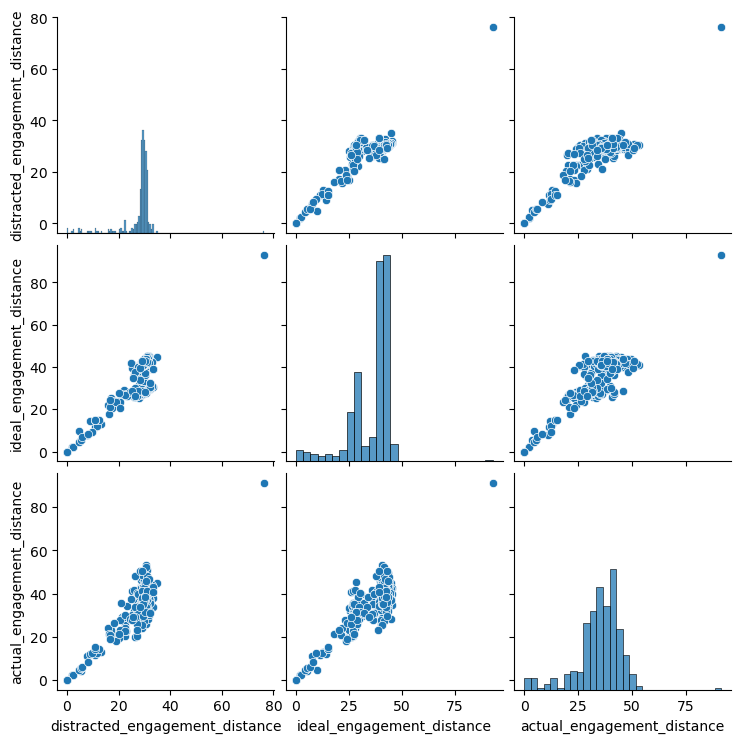

In [44]:

columns_list = ['distracted_engagement_distance', 'ideal_engagement_distance', 'actual_engagement_distance']
PairGrid_obj = sns.pairplot(distance_delta_df[columns_list])


The larger mode is responders who have moved the walkers previous to engaging with them. The smaller mode is where the ideal is wrongly computed because the walkers are only where they were first engaged, and therefore at a closer distance to the wavers.

In [21]:

df = distance_delta_df.sort_values('actual_ideal_delta')


## Visualize that there are responders taking a shorter Euclidean distance to engage the patients than the ideal
### Here is an example where the ideal has a larger Euclidean footprint than the actual.

In [8]:

session_uuid = df.iloc[0].session_uuid
scene_id = df.iloc[0].scene_id
mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id)
scene_df = frvrs_logs_df[mask_series]
color_dict = {
    'Gary_3 Root': '#a6cee3', 'Mike_7 Root': '#1f78b4', 'Gloria_6 Root': '#b2df8a', 'Bob_0 Root': '#33a02c', 'Lily_4 Root': '#fb9a99',
    'Gary_1 Root': '#fdbf6f', 'Gary_9 Root': '#ff7f00', 'Lily_2 Root': '#cab2d6', 'Mike_5 Root': '#6a3d9a', 'Gloria_8 Root': '#bbbb00', 'Helga_10 Root': '#b15928'
}


Does a walker still move to the safe area if all patients are first told to move _after_ this particular patient has been engaged? I don't think so. It looks like the first time the command was logged, nobody moved, then the first walker was engaged, then the rest of the walkers moved _after_ the second command was logged.

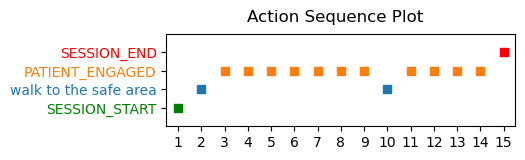

In [9]:

# Plot what the actions look like
import humanize

summary_statistics_df = data_frames_dict['summary_statistics_df']
time_groups_dict = nu.load_object('time_groups_dict')
alphabet_list = ['SESSION_START', 'walk to the safe area', 'PATIENT_ENGAGED', 'SESSION_END']
actions_mask_series = frvrs_logs_df.action_type.isin(alphabet_list)
actions_mask_series |= ((frvrs_logs_df.action_type == 'VOICE_COMMAND') & frvrs_logs_df.voice_command_message.isin(alphabet_list))
scene_tuple = (session_uuid, scene_id)
sequence = [s for s in time_groups_dict[scene_tuple] if s in alphabet_list]
title = f'Action Sequence Plot for UUID {session_uuid} ({humanize.ordinal(scene_id+1)} Scene)'
title = f'Action Sequence Plot'
fig, ax = fu.plot_sequence_by_scene_tuple(
    scene_tuple, sequence, frvrs_logs_df, summary_statistics_df=summary_statistics_df, actions_mask_series=actions_mask_series,
    suptitle=title, verbose=False
)


Here's the actual:

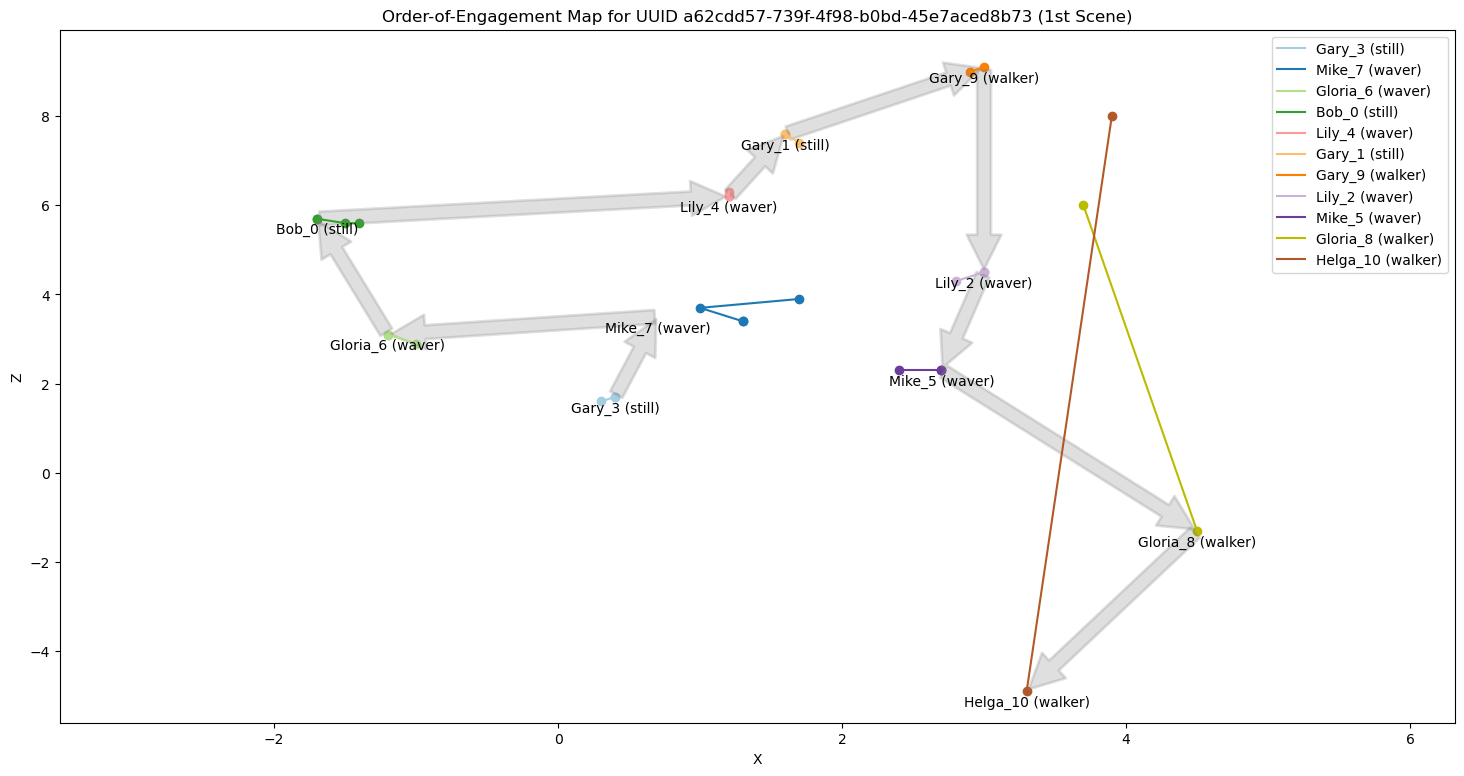

In [10]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=None, color_dict=color_dict, verbose=False)


Here's the ideal:

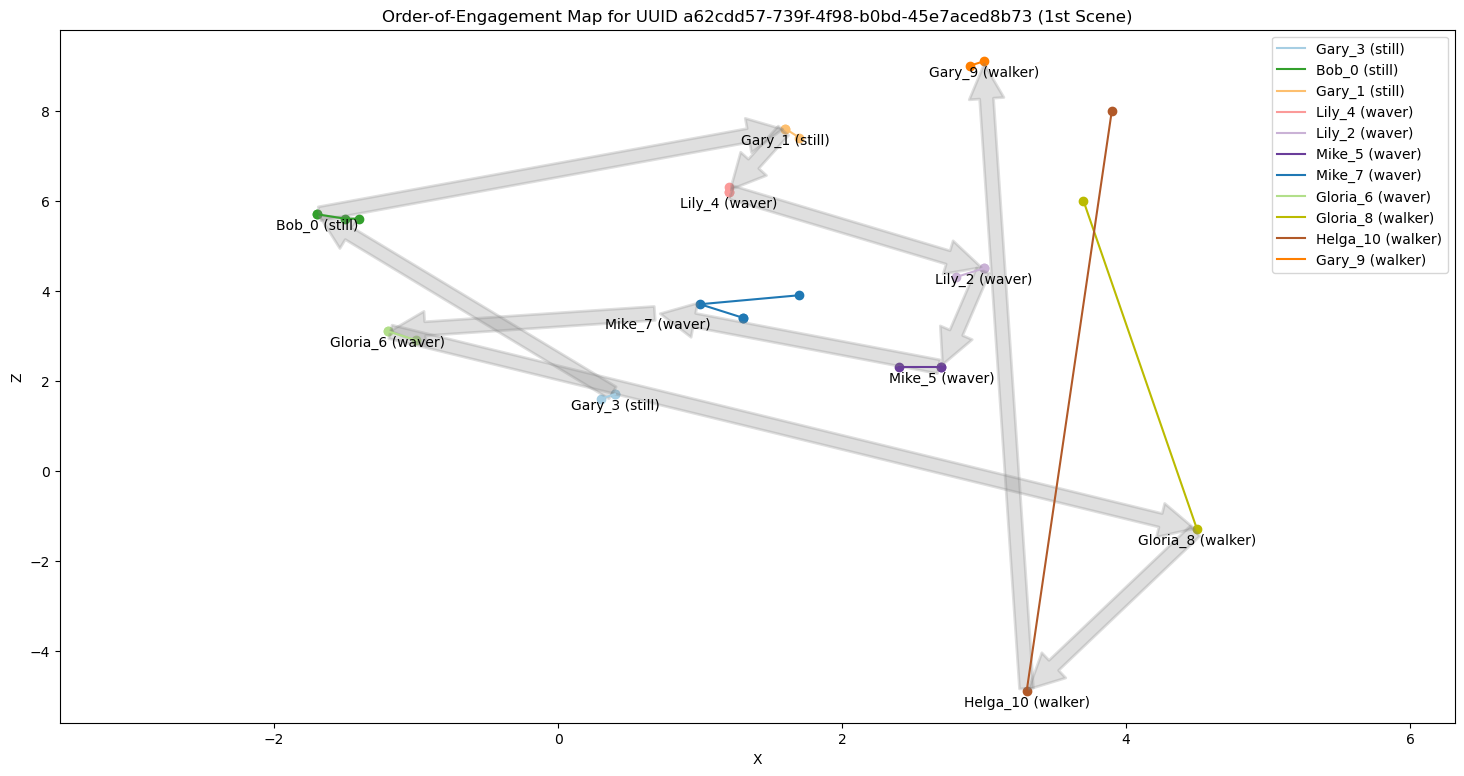

In [11]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=fu.get_ideal_engagement_order(scene_df), color_dict=color_dict)


### Here is an example where the actual has a larger Euclidean footprint than the ideal.

In [12]:

mask_series = (frvrs_logs_df.session_uuid == df.iloc[-1].session_uuid) & (frvrs_logs_df.scene_id == df.iloc[-1].scene_id)
scene_df = frvrs_logs_df[mask_series]
color_dict = {
    'Lily_7 Root': '#a6cee3', 'Mike_6 Root': '#1f78b4', 'Gloria_8 Root': '#b2df8a', 'Helga_0 Root': '#33a02c', 'Mike_3 Root': '#fb9a99',
    'Lily_1 Root': '#fdbf6f', 'Gloria_2 Root': '#ff7f00', 'Mike_9 Root': '#cab2d6', 'Gary_5 Root': '#6a3d9a', 'Bob_10 Root': '#bbbb00', 'Bob_4 Root': '#b15928'
}


Here's the actual:

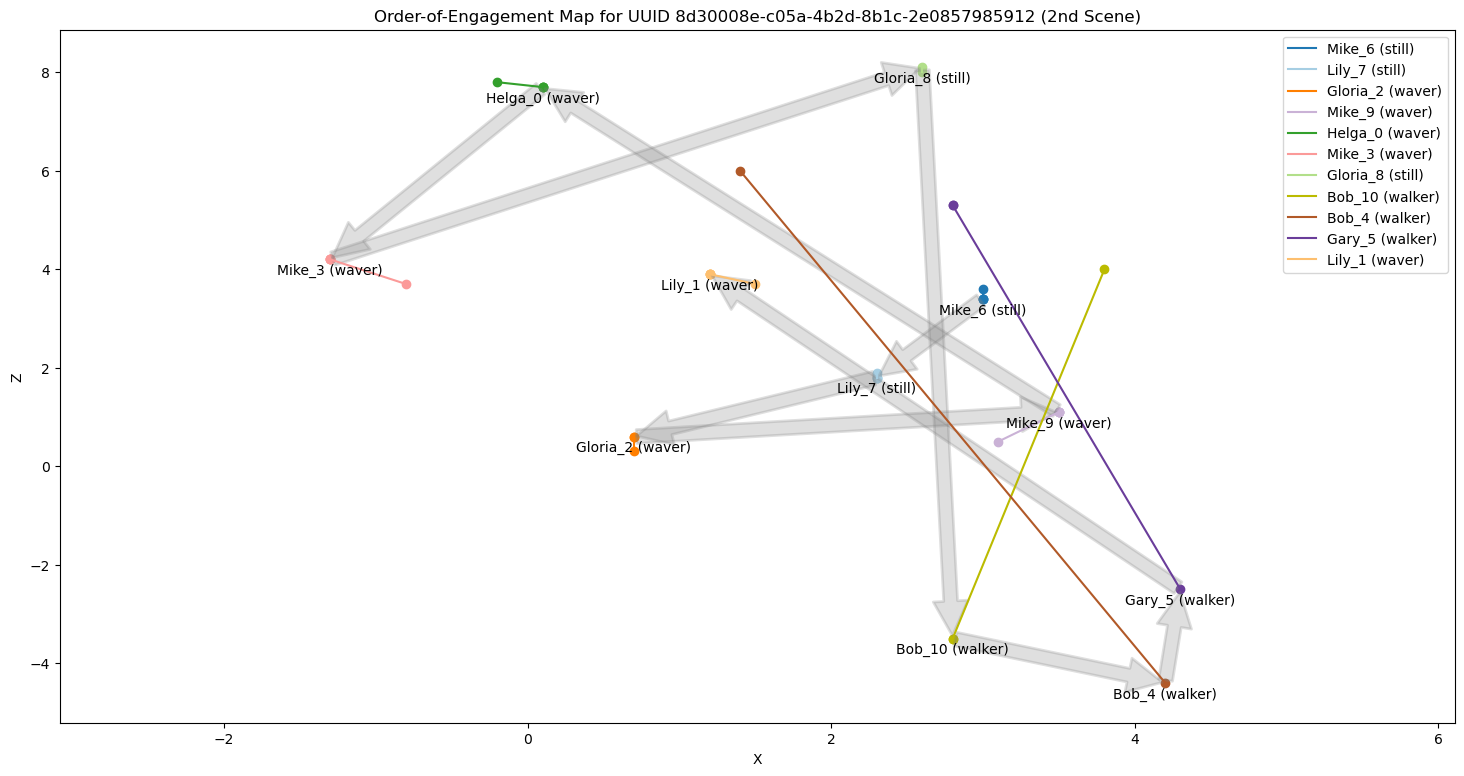

In [13]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=None, color_dict=color_dict, verbose=False)


Here's the ideal:

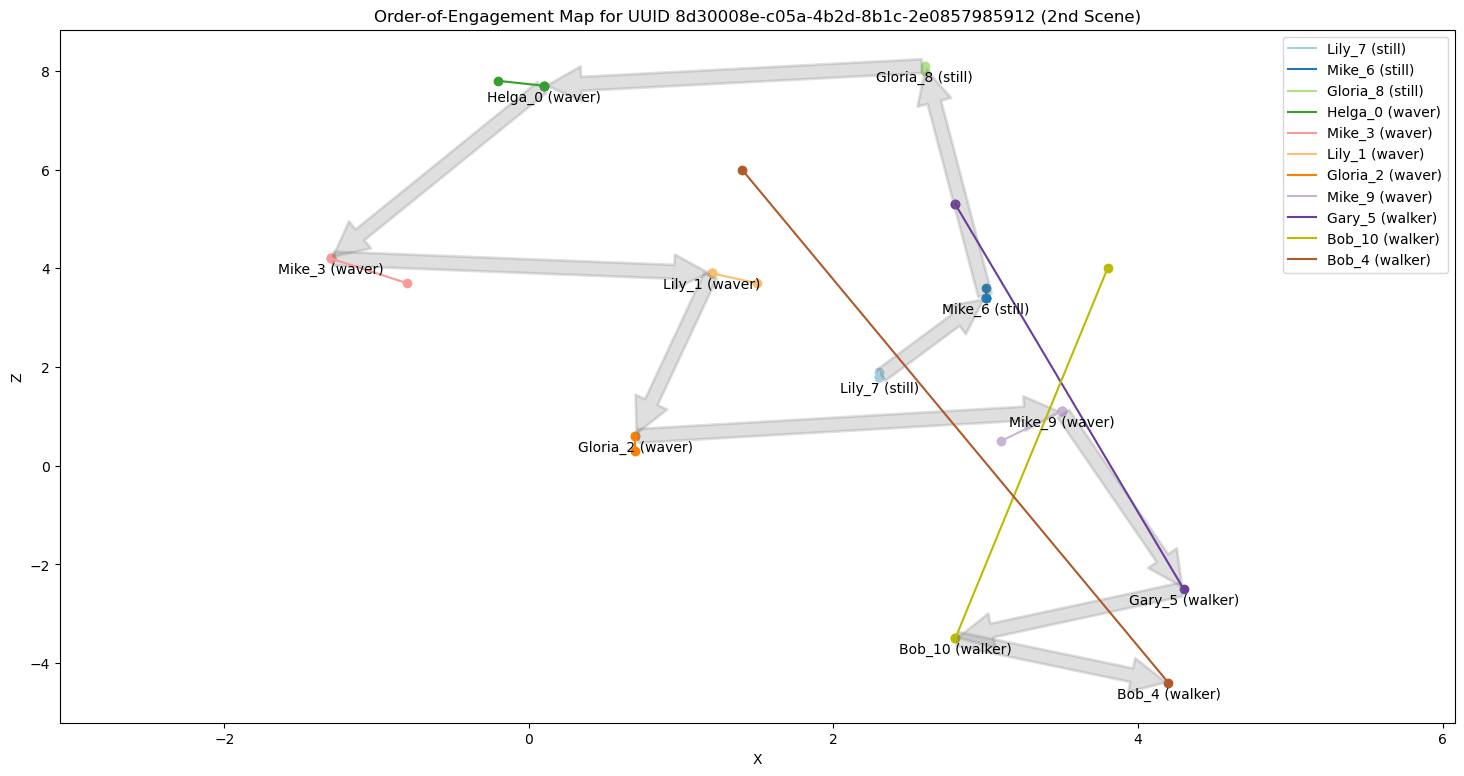

In [14]:

fig, ax = fu.visualize_order_of_engagement(scene_df, engagement_order=fu.get_ideal_engagement_order(scene_df), color_dict=color_dict)


## Prove that they're doing a nearest-neighbor algorithm of their own without reference to the SORT order


The distracted ordering is just the responder doing a nearest-neighbor algorithm without respect to SORT. The more the responder is short-cutting the ideal distance, the closer they are to the distracted ordering.

In [48]:

# Define a colormap
cmap = plt.cm.coolwarm

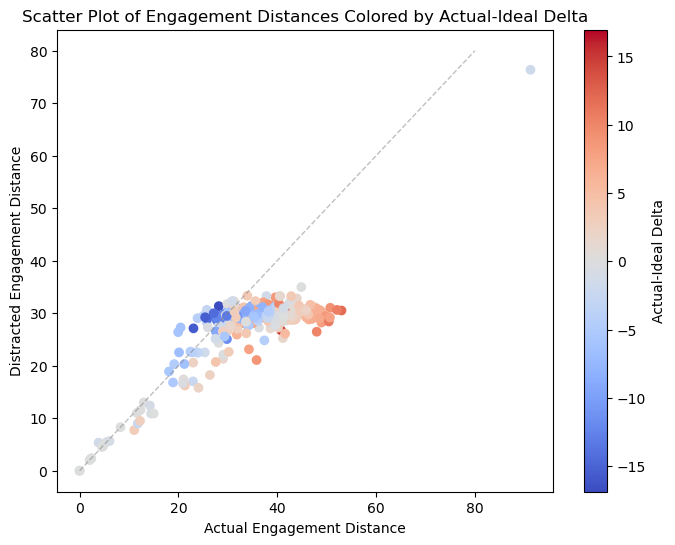

In [49]:

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(distance_delta_df['actual_engagement_distance'], distance_delta_df['distracted_engagement_distance'], c=distance_delta_df['actual_ideal_delta'], cmap=cmap)

# Add labels and title
plt.xlabel('Actual Engagement Distance')
plt.ylabel('Distracted Engagement Distance')
plt.title('Scatter Plot of Engagement Distances Colored by Actual-Ideal Delta')

# Add a colorbar
plt.colorbar(label='Actual-Ideal Delta')

# Add a dashed diagonal line x=y
plt.plot([0, 80], [0, 80], linestyle='--', color='gray', linewidth=1, alpha=0.5);

In [11]:

from scipy.stats import spearmanr

# Calculate Spearman's rank correlation coefficient and p-value
distance_delta_df['actual_distracted_abs'] = distance_delta_df['actual_distracted_delta'].map(lambda x: abs(x))
spearman_corr, p_value = spearmanr(distance_delta_df['actual_ideal_delta'], distance_delta_df['actual_distracted_abs'])

# Print the results
print(f"Spearman's rank correlation coefficient: {spearman_corr}")
print(f'P-value: {p_value}')

# Check for significance (you can choose a significance level, e.g., 0.05)
if p_value < 0.05: print('The correlation is statistically significant.')
else: print('The correlation is not statistically significant.')

Spearman's rank correlation coefficient: 0.45427822194358486
P-value: 4.0192224997822503e-19
The correlation is statistically significant.


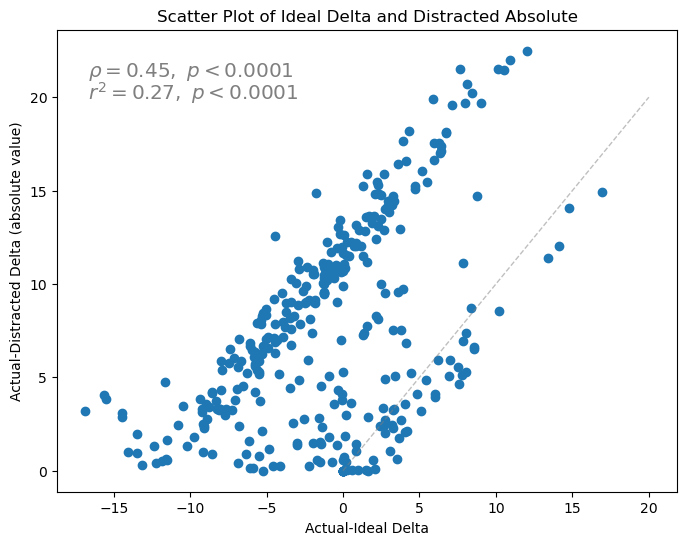

In [14]:

# Mask deltas greater than zero

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(distance_delta_df['actual_ideal_delta'], distance_delta_df['actual_distracted_abs'])

# Add labels and title
ax.set_xlabel('Actual-Ideal Delta')
ax.set_ylabel('Actual-Distracted Delta (absolute value)')
ax.set_title('Scatter Plot of Ideal Delta and Distracted Absolute')

# Add a dashed diagonal line x=y
ax.plot([0, 20], [0, 20], linestyle='--', color='gray', linewidth=1, alpha=0.5)

# Annotate with Spearman's Rank Correlation Coefficient
s_str = nu.get_spearman_rho_value_latex(distance_delta_df['actual_ideal_delta'], distance_delta_df['actual_distracted_abs'])
text_tuple = ax.text(0.05, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Annotate with Coefficient of Determination
s_str = nu.get_r_squared_value_latex(distance_delta_df['actual_ideal_delta'], distance_delta_df['actual_distracted_abs'])
text_tuple = ax.text(0.05, 0.85, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

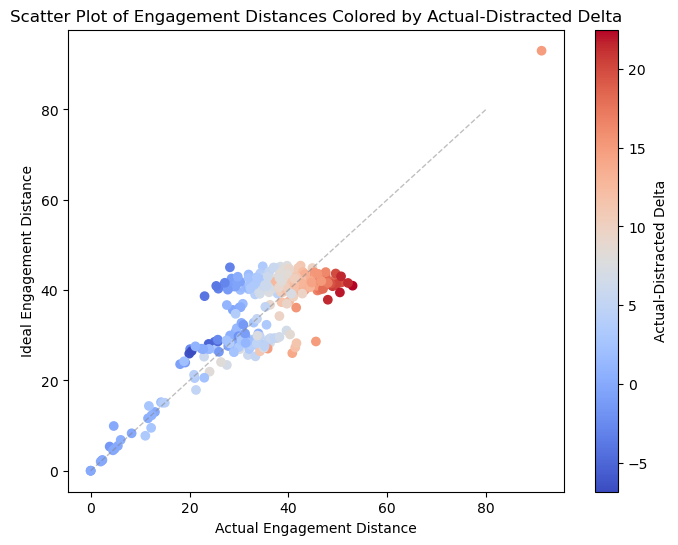

In [35]:

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(distance_delta_df['actual_engagement_distance'], distance_delta_df['ideal_engagement_distance'], c=distance_delta_df['actual_distracted_delta'], cmap=cmap)

# Add labels and title
plt.xlabel('Actual Engagement Distance')
plt.ylabel('Ideal Engagement Distance')
plt.title('Scatter Plot of Engagement Distances Colored by Actual-Distracted Delta')

# Add a colorbar
plt.colorbar(label='Actual-Distracted Delta')

# Add a dashed diagonal line x=y
plt.plot([0, 80], [0, 80], linestyle='--', color='gray', linewidth=1, alpha=0.5);

In [46]:

distance_delta_df.sample(8).T

,303,33,26,69,267,218,210,35
session_uuid,e3c2b4c6-d8b7-4b64-8cd0-7ca0e622f9b5,17962d45-8e90-4b50-86e7-77451042aac8,14a344df-eee2-4fd1-b182-e3cdacd9026c,33e7d6b6-2868-42e6-8967-d6890efb87a7,d11543fd-7b7f-4883-bd69-afe8128a76f2,a98b7327-dfd7-43c2-86e7-b5080ec86806,a40659ab-dfbf-43ab-91cb-72a48a82c426,1813599d-cfde-45f0-8555-428b57478ebb
scene_id,1,0,1,1,0,1,0,0
last_still_engagement,285708.0,428206.0,185204.0,224667.0,304632.0,147668.0,145451.0,273902.0
actual_engagement_distance,39.818552,33.346336,37.791335,42.523485,22.784179,37.184002,32.60482,32.607046
ideal_engagement_distance,43.571339,25.324633,41.232523,43.20613,26.919033,29.371862,27.752938,41.724931
measure_of_ideal_ordering,0.573605,-0.094147,0.683919,0.410011,-0.11098,0.178781,0.630695,0.266995
distracted_engagement_distance,31.312498,28.059565,29.616094,32.059331,22.542482,32.081168,28.498076,30.302294
measure_of_distracted_ordering,0.066558,0.431647,0.148986,0.586998,0.155089,0.069493,0.361863,0.603243
actual_ideal_delta,-3.752787,8.021704,-3.441188,-0.682645,-4.134854,7.81214,4.851882,-9.117885
actual_distracted_delta,8.506054,5.286772,8.175241,10.464154,0.241697,5.102834,4.106745,2.304752


In [53]:

# Get ordering measure against both ideal and distracted

for (session_uuid, scene_id), _ in distance_delta_df.groupby(fu.scene_groupby_columns):
    
    # Get the whole scene
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    scene_df = frvrs_logs_df[mask_series]
    
    actual_engagement_order = fu.get_actual_engagement_order(scene_df, verbose=False)
    ideal_engagement_order = fu.get_ideal_engagement_order(scene_df, verbose=False)
    distracted_engagement_order = fu.get_distracted_engagement_order(scene_df, tuples_list=actual_engagement_order, verbose=False)
    
    # Calculate the R-squared adjusted value as a measure of right ordering
    X, y = Series([t[1] for t in ideal_engagement_order]).values.reshape(-1, 1), Series([t[1] for t in actual_engagement_order]).values.reshape(-1, 1)
    if X.shape[0]:
        X1 = sm.add_constant(X)
        try: measure_of_ideal_ordering = sm.OLS(y, X1).fit().rsquared_adj
        except: measure_of_ideal_ordering = np.nan
    else: measure_of_ideal_ordering = np.nan
    X, y = Series([t[1] for t in distracted_engagement_order]).values.reshape(-1, 1), Series([t[1] for t in actual_engagement_order]).values.reshape(-1, 1)
    if X.shape[0]:
        X1 = sm.add_constant(X)
        try: measure_of_distracted_ordering = sm.OLS(y, X1).fit().rsquared_adj
        except: measure_of_distracted_ordering = np.nan
    else: measure_of_distracted_ordering = np.nan
    break

In [54]:

measure_of_ideal_ordering, measure_of_distracted_ordering

(0.2344044789174461, 0.9986943800415076)

In [51]:

y

array([[336847],
       [343531],
       [346066],
       [381184],
       [384722],
       [409276],
       [438270],
       [607365],
       [633205],
       [704250]])

In [44]:

distracted_engagement_order

[('Gloria_8 Root', 346066, (0.6, 1.4), 'walker'), ('Helga_10 Root', 343531, (0.8, 1.5), 'walker'), ('Gary_3 Root', 336847, (0.0, 2.0), 'still'), ('Gloria_6 Root', 384722, (-1.0, 3.2), 'waver'), ('Mike_7 Root', 381184, (1.4, 4.0), 'waver'), ('Lily_2 Root', 409276, (3.0, 4.0), 'waver'), ('Mike_5 Root', 438270, (2.6, 2.0), 'waver'), ('Lily_4 Root', 607365, (1.4, 6.0), 'waver'), ('Gary_1 Root', 633205, (2.0, 7.0), 'still'), ('Bob_0 Root', 704250, (-1.0, 6.0), 'still')]

In [45]:

actual_sequence

0     335204
8     343531
9     346066
3     381184
4     384722
5     409276
6     438270
7     607365
1     633205
2     693191
10    809148
dtype: int64

In [47]:

ideal_sequence

0     335204
1     633205
2     693191
3     381184
4     384722
5     409276
6     438270
7     607365
8     343531
9     346066
10    809148
dtype: int64


## In looking at the maps, does a small footprint correlate to efficient performance?


Here's a better scatterplot than the original, using my new Ideal Ordering. The negative deltas are an improvement of the ideal ordering over the actual ordering:

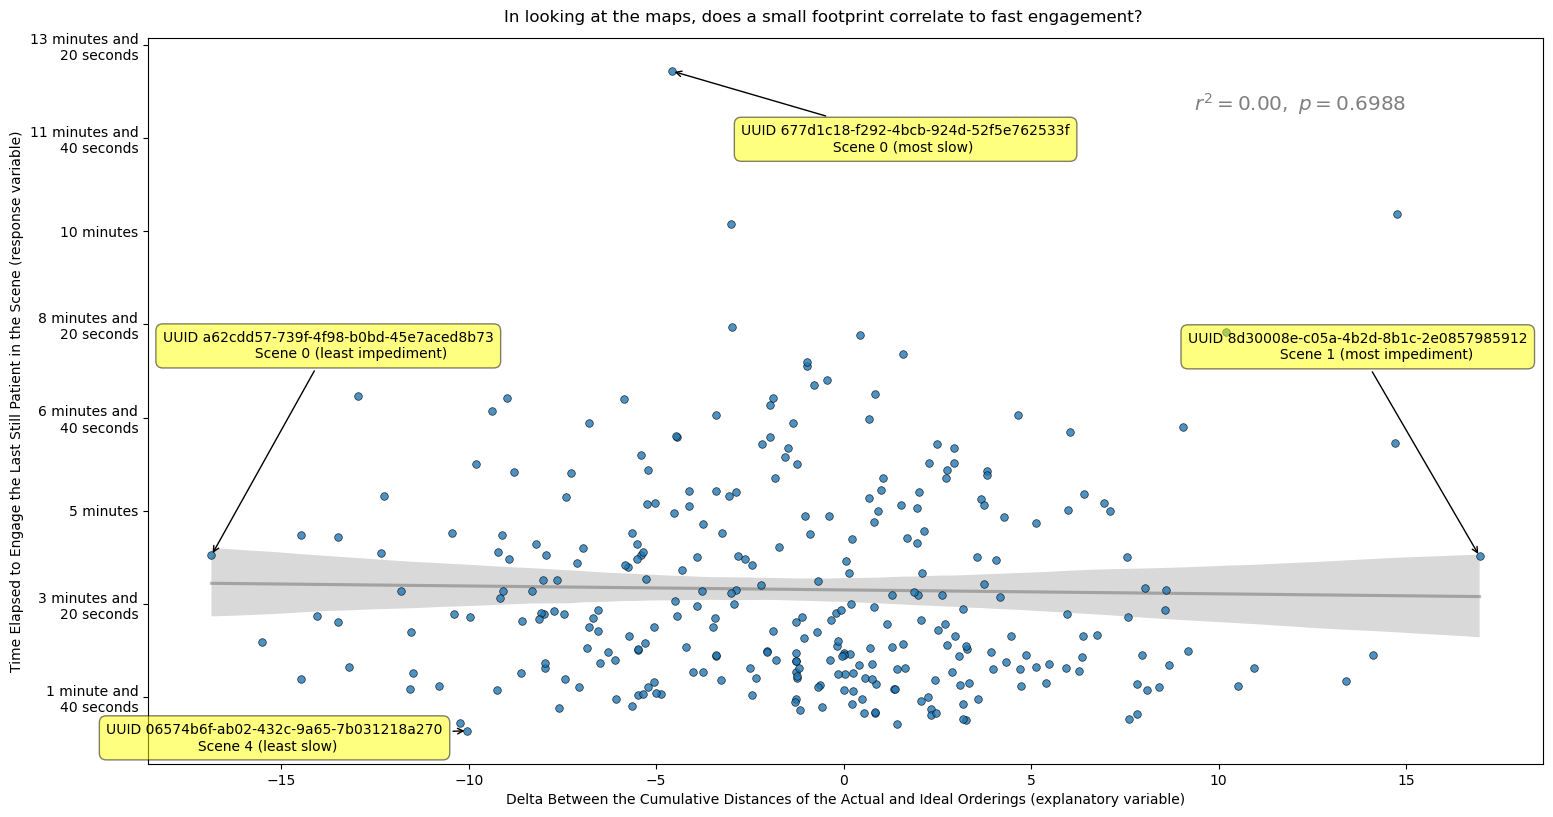

In [12]:

# Distance travelled and efficiency vs accuracy
# (ie in looking at the maps, does a small footprint correlate to efficient performance?)
import pandas as pd
from datetime import timedelta

df = distance_delta_df.set_index(fu.scene_groupby_columns)
df.index = Index([f'UUID {idx_tuple[0]}\n                     Scene {idx_tuple[1]}' for idx_tuple in df.index.tolist()])
fig = nu.first_order_linear_scatterplot(
    df,
    'actual_ideal_delta',
    'last_still_engagement',
    xlabel_str='Delta Between the Cumulative Distances of the Actual and Ideal Orderings (explanatory variable)',
    ylabel_str='Time Elapsed to Engage the Last Still Patient in the Scene (response variable)',
    x_adj='impediment',
    y_adj='slow',
    title='In looking at the maps, does a small footprint correlate to fast engagement?',
    idx_reference=None,
    annot_reference=None,
    aspect_ratio=None,
    least_x_xytext=(-35, 140),
    most_x_xytext=(-210, 140),
    least_y_xytext=(-260, -16),
    most_y_xytext=(50, -60),
    reference_xytext=None,
    color_list=None,
)
ax = fig.get_axes()[0]

# Humanize y tick labels; why you have to set them twice (I do not know)
ax.set_yticklabels([text_obj for text_obj in ax.get_yticklabels()]);
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_position = text_obj.get_position()[1]
    time_delta = timedelta(milliseconds=text_position)
    precise_delta = humanize.precisedelta(time_delta)
    text_obj.set_text(precise_delta.replace(', ', ',\n').replace(' and ', ' and\n'))
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list);